In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
import pandas as pd
from ast import literal_eval

# Sample data
movie_actor_data = pd.read_csv('updated_movies_with_actors.csv')

print(movie_actor_data.head())
print(movie_actor_data['top_actors'].isnull().sum())

   movieId                           title                 genres  \
0   120510          Value for Money (1955)         Comedy|Romance   
1   212955             Face of Evil (1996)         Drama|Thriller   
2   193912              Spring 1941 (2007)      Drama|Romance|War   
3   163921               Wolf Creek (2016)  Crime|Horror|Thriller   
4   126652  Raven the Little Rascal (2012)     Animation|Children   

                                          top_actors  
0  ['Nicolas Cage', 'Elisabeth Shue', 'Julian San...  
1  ['Emma Thompson', 'Jonathan Pryce', 'Steven Wa...  
2   ['Susan Sarandon', 'Sean Penn', 'Robert Prosky']  
3  ['Richard Harris', 'James Earl Jones', 'Vusi K...  
4   ['Peter Weller', 'Roy Dupuis', 'Jennifer Rubin']  
515


In [ ]:


user_ratings_data = pd.read_csv('ratings_set1.csv')

# Convert actor list strings to actual lists using literal_eval
# print(movie_actor_data.head())
# print(type(movie_actor_data['top_actors']))
movie_actor_data['top_actors'] = movie_actor_data['top_actors'].fillna('[]')
movie_actor_data['top_actors'] = movie_actor_data['top_actors'].apply(literal_eval)
# Merge user ratings with movie-actor data on movieId
merged_data = user_ratings_data.merge(movie_actor_data, on='movieId', how='inner')

merged_data = merged_data.explode('top_actors')

user_actor_ratings = merged_data.groupby(['userId', 'top_actors'])['rating'].mean().reset_index()
user_actor_ratings.columns = ['userId', 'actor', 'average_rating']
pd.DataFrame.to_csv(user_actor_ratings, 'user_actor_ratings.csv', index=False)


In [71]:
import pandas as pd
import numpy as np

# Step 1: Load and Process the Data
# Assuming the CSV file has columns: user, actor, rating
data = pd.read_csv("user_actor_ratings.csv")

# Get unique users and actors
users = data['userId'].unique()
actors = data['actor'].unique()

# Create mappings for users and actors to indices
user_to_index = {user: idx for idx, user in enumerate(users)}
actor_to_index = {actor: idx for idx, actor in enumerate(actors)}

print(type(user_to_index))

# see first few entries of user_to_index
print({k: user_to_index[k] for k in list(user_to_index)[:5]})

<class 'dict'>
{np.int64(5): 0, np.int64(7): 1, np.int64(13): 2, np.int64(34): 3, np.int64(71): 4}


In [72]:
print(actors.shape)

(15012,)


In [73]:
# Initialize the user-actor interaction matrix with NaNs for missing values
num_users = len(users)
num_actors = len(actors)
R = np.full((num_users, num_actors), np.nan)

# Populate the matrix with ratings
for _, row in data.iterrows():
    user_idx = user_to_index[row['userId']]
    actor_idx = actor_to_index[row['actor']]
    R[user_idx, actor_idx] = row['average_rating']



In [12]:
# print the first few rows of the matrix
print(R[:5, :5])

[[3.  3.  1.  3.  3. ]
 [4.  4.  5.  3.  3. ]
 [nan nan 5.  nan nan]
 [3.5 3.5 4.  nan nan]
 [4.  4.  4.  3.  3. ]]


In [ ]:
# Step 2: Implement Matrix Factorization
class MatrixFactorization:
    def __init__(self, R, num_factors=10, learning_rate=0.01, regularization=0.02, epochs=100):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.epochs = epochs
        # Initialize latent factors
        self.P = np.random.normal(scale=1./self.num_factors, size=(self.num_users, self.num_factors))
        self.Q = np.random.normal(scale=1./self.num_factors, size=(self.num_items, self.num_factors))

    def train(self):
        for epoch in range(self.epochs):
            for i in range(self.num_users):
                for j in range(self.num_items):
                    if not np.isnan(self.R[i, j]):  # Only consider known ratings
                        error = self.R[i, j] - self.predict(i, j)
                        # Update user and item latent factors with gradient clipping
                        self.P[i, :] += np.clip(
                            self.learning_rate * (error * self.Q[j, :] - self.regularization * self.P[i, :]),
                            -5.0, 5.0
                        )
                        self.Q[j, :] += np.clip(
                            self.learning_rate * (error * self.P[i, :] - self.regularization * self.Q[j, :]),
                            -5.0, 5.0
                        )

            mse = self.compute_mse()
            print(f"Epoch {epoch+1}/{self.epochs}, MSE: {mse}")


    def predict(self, i, j):
        """ Predict the rating of user i for item j """
        return np.dot(self.P[i, :], self.Q[j, :])

    def compute_mse(self):
        """ Compute Mean Squared Error only for known ratings """
        xs, ys = np.where(~np.isnan(self.R))  # indices of known ratings
        mse = 0
        for x, y in zip(xs, ys):
            mse += (self.R[x, y] - self.predict(x, y)) ** 2
        return mse / len(xs) if len(xs) > 0 else np.nan  # avoid division by zero


    def full_matrix(self):
        """ Compute the full predicted matrix for all user-item combinations """
        return np.dot(self.P, self.Q.T)

# Step 3: Train the Model
mf = MatrixFactorization(R, num_factors=10, learning_rate=0.001, regularization=0.02, epochs=20)
mf.train()

# Step 4: Make Predictions
# Get the full predicted rating matrix
predicted_ratings = mf.full_matrix()
# store this matrix in a dataframe
# predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=actors, index=users)

Epoch 1/20, MSE: 13.768358472975638
Epoch 2/20, MSE: 13.669010469925448
Epoch 3/20, MSE: 12.339414472494008
Epoch 4/20, MSE: 7.432898880705396
Epoch 5/20, MSE: 4.773132653537465
Epoch 6/20, MSE: 3.511048533861219
Epoch 7/20, MSE: 2.815012603436241
Epoch 8/20, MSE: 2.3809409749000787
Epoch 9/20, MSE: 2.0848422914624205
Epoch 10/20, MSE: 1.8700960178044874
Epoch 11/20, MSE: 1.7073582052115694
Epoch 12/20, MSE: 1.5798922480322555
Epoch 13/20, MSE: 1.4774561554847905
Epoch 14/20, MSE: 1.3934388820245847
Epoch 15/20, MSE: 1.3233826836539517
Epoch 16/20, MSE: 1.2641648514574555
Epoch 17/20, MSE: 1.2135227531197594
Epoch 18/20, MSE: 1.1697688966938975
Epoch 19/20, MSE: 1.1316147977836584
Epoch 20/20, MSE: 1.098058313169938


In [ ]:
# load the predicted matrix in a data frame
# predicted_ratings = pd.read_csv('predicted_ratings.csv')

In [ ]:
# predicted_ratings.rename(columns={"Unnamed: 0": "userId"}, inplace=True)

# print(predicted_ratings.head())

   userId  Bubba Smith  Busta Rhymes  Daisy Ridley  Dustin Hoffman  \
0       5     2.669740      2.692209      2.842414        2.093095   
1       7     3.640309      3.663797      4.052796        2.853667   
2      13     4.181514      4.182399      4.551845        3.216027   
3      34     3.628466      3.635095      4.289625        2.730943   
4      71     3.652930      3.661342      4.302622        2.811992   

   Edward Burns  Ian Hunter  Jane McGregor  Jeanette MacDonald  Lew Ayres  \
0      2.107204    2.815074       2.793276            2.844548   2.849020   
1      2.880304    3.909656       3.808076            3.940346   3.955694   
2      3.221108    4.390002       4.351872            4.415041   4.428867   
3      2.756484    4.004546       3.907140            4.004987   4.007619   
4      2.820408    3.921854       3.844358            3.925940   3.938724   

   ...  Kanae Uotani  Erin Daniels  Larisa Oleynik       DMX  Geny Prado  \
0  ...     -0.089074      0.114991      

In [ ]:
# print(predicted_ratings.shape)

# user_predictions = predicted_ratings[predicted_ratings['userId'] == 5].iloc[0, 1:]

# print(user_predictions)

(7991, 15013)
Bubba Smith            2.669740
Busta Rhymes           2.692209
Daisy Ridley           2.842414
Dustin Hoffman         2.093095
Edward Burns           2.107204
                         ...   
Genésio Arruda        -0.074184
Kat Wanger             0.230669
Method Man             0.259120
Nicholas Trivisonno    0.058650
Peter Carroll         -0.017741
Name: 0, Length: 15012, dtype: float64


In [77]:
import json

all_recommendations_actors = []
all_recommendations_ratings = []

for user_id in range(mf.num_users):
    try:
        # Get the actual userId from the mapping
        actual_user_id = list(user_to_index.keys())[list(user_to_index.values()).index(user_id)]

        # Get predictions for the user
        user_predictions = predicted_ratings[user_id]
        # user_predictions = predicted_ratings[predicted_ratings['userId'] == actual_user_id].iloc[0, 1:]

        # Create a DataFrame for recommendations
        recommendations = pd.DataFrame({
            'actor': actors,
            'predicted_rating': user_predictions
        })

        # Sort by predicted ratings and get the top 10
        recommendations = recommendations.sort_values(by='predicted_rating', ascending=False).head(10)
        top_actors_list = recommendations['actor'].tolist()

        # Convert top actors and their ratings to dictionary
        top_actors_dict = recommendations.set_index('actor')['predicted_rating'].to_dict()

        # Append to the recommendations lists
        all_recommendations_actors.append({
            'userId': actual_user_id,
            'top_actors': top_actors_list
        })

        # Optionally handle ratings if needed
        # all_recommendations_ratings.append({
        #     'userId': actual_user_id,
        #     'top_actors': {k: int(v) for k, v in top_actors_dict.items()}  # Convert to int
        # })

    except IndexError:
        print(f"Error occurred for userId: {user_id}")

# Save the results
actors_df = pd.DataFrame(all_recommendations_actors)
actors_df.to_csv('top_actors_list.csv', index=False)


In [ ]:
# print(actors_df.head())

   userId                                         top_actors
0       5  [Matt Berry, Lew Ayres, Jeanette MacDonald, Ma...
1       7  [Matt Berry, Marion Cotillard, Daisy Ridley, L...
2      13  [Matt Berry, Marion Cotillard, Daisy Ridley, L...
3      34  [Matt Berry, Daisy Ridley, Marion Cotillard, D...
4      71  [Matt Berry, Marion Cotillard, Daisy Ridley, M...


In [ ]:
# convert the dataframe to np array
# predicted_ratings_np = predicted_ratings.to_numpy()

In [78]:
print(predicted_ratings.shape)

(7991, 15012)


In [ ]:
import numpy as np

def precision_at_k_threshold(y_true, y_pred, k, threshold):
    """
    Calculate Precision@k with a relevance threshold.
    """
    # Get the indices of the top-k predicted items
    top_k_pred = np.argsort(y_pred)[-k:][::-1]
    # print the top k predictions with the values of predictinos
    # Print the top k predictions with their values and indices
    print("Top-k predictions:")
    for idx in top_k_pred:
        print(f"Index: {idx}, Predicted Value: {y_pred[idx]}")

    # Determine relevant items based on the threshold
    relevant_items = np.where(y_true >= threshold)[0]
    # Count how many top-k items are relevant
    relevant_count = len(set(top_k_pred).intersection(relevant_items))
    return relevant_count / k

def recall_at_k_threshold(y_true, y_pred, k, threshold):
    """
    Calculate Recall@k with a relevance threshold.
    """
    # Get the indices of the top-k predicted items
    top_k_pred = np.argsort(y_pred)[-k:][::-1]
    # Determine relevant items based on the threshold
    relevant_items = np.where(y_true >= threshold)[0]
    # Count how many top-k items are relevant
    relevant_count = len(set(top_k_pred).intersection(relevant_items))
    # Return recall, handling the case when there are no relevant items
    return relevant_count / len(relevant_items) if len(relevant_items) > 0 else 0

def ndcg_at_k_threshold(y_true, y_pred, k, threshold):
    """
    Calculate NDCG@k with a relevance threshold.
    """
    # Get the indices of the top-k predicted items
    top_k_pred = np.argsort(y_pred)[-k:][::-1]
    # Determine the relevance of top-k items based on the threshold
    relevance = np.array([1 if idx in np.where(y_true >= threshold)[0] else 0 for idx in top_k_pred])
    # Calculate DCG
    dcg = np.sum(relevance / np.log2(np.arange(2, k + 2)))
    # Calculate IDCG (ideal DCG)
    ideal_relevance = sorted(relevance, reverse=True)
    idcg = np.sum(ideal_relevance / np.log2(np.arange(2, k + 2)))
    return dcg / idcg if idcg > 0 else 0

# Example: Calculate Precision@k, Recall@k, NDCG@k for user 0 with k=5

user_id = input("Enter a User id to check for recommendation:") # You can change this to test for other users
print(user_id)
user_id = int(user_id)
print(R.shape)
k = 5
threshold = 2.5  # Define the relevance threshold
y_true = R[user_id]  # True ratings for the user
y_pred = predicted_ratings[user_id]  # Predicted ratings for the user
# actual_user_id = list(user_to_index.keys())[list(user_to_index.values()).index(user_id)]
# y_pred = predicted_ratings[predicted_ratings['userId'] == actual_user_id].iloc[0, 1:]
# y_pred = predicted_ratings_np[user_id][1:]

precision = precision_at_k_threshold(y_true, y_pred, k, threshold)
recall = recall_at_k_threshold(y_true, y_pred, k, threshold)
ndcg = ndcg_at_k_threshold(y_true, y_pred, k, threshold)

print(f"Precision@{k}: {precision}")
print(f"Recall@{k}: {recall}")
print(f"NDCG@{k}: {ndcg}")

# print(y_true)
# print(y_pred)

8
(7991, 15012)
Top-k predictions:
Index: 10, Predicted Value: 4.609318940127917
Index: 9, Predicted Value: 4.603338713128888
Index: 2, Predicted Value: 4.6027792287151685
Index: 49, Predicted Value: 4.314091198642432
Index: 24, Predicted Value: 4.314009012772788
Precision@5: 0.4
Recall@5: 0.025
NDCG@5: 0.5012658353418871


/tmp/ipykernel_8320/167971765.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='predicted_rating', y='actor', data=recommendations, palette="Blues_d")


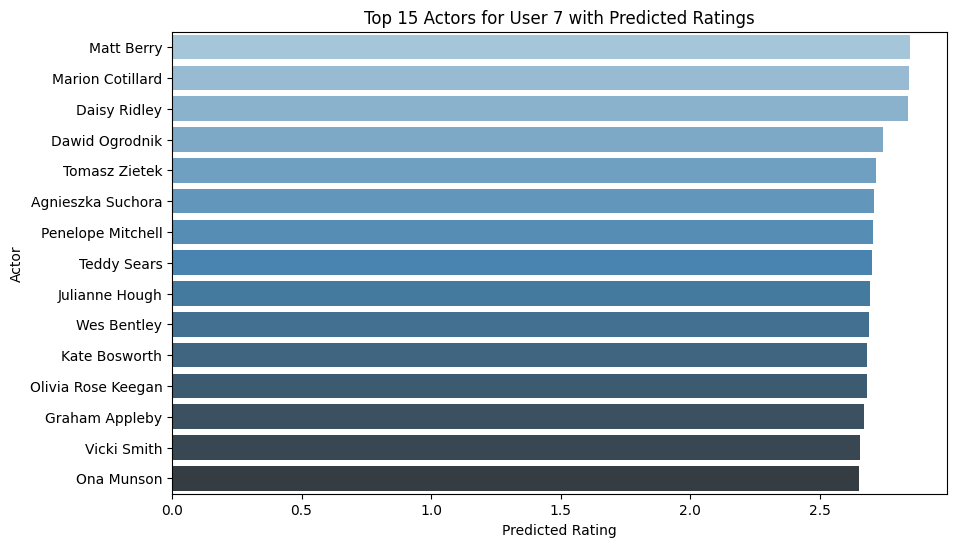

/tmp/ipykernel_8320/167971765.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='actor', data=actor_count_df, palette="viridis")


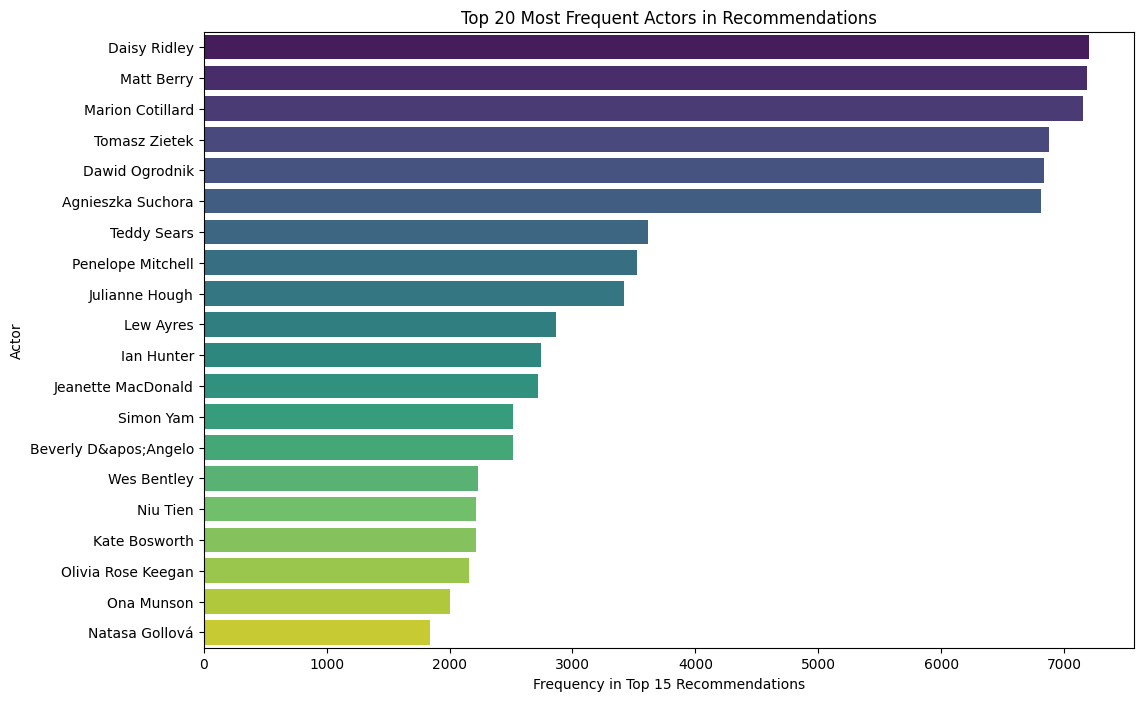

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming 'mf' is your trained MatrixFactorization object and 'predicted_ratings' is the matrix of predicted ratings
# Assume 'actors' is a list of actors corresponding to the items (movies/actors in the matrix)
user_id = input("Enter a User id to check for recommendation:") # You can change this to test for other users
user_id = int(user_id)
# 1. **Top 15 Actors for a Random User**
user_predictions = predicted_ratings[user_id]
recommendations = pd.DataFrame({
    'actor': actors,  # List of actors corresponding to the items
    'predicted_rating': user_predictions
})
recommendations = recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

# Plotting the Top 15 actors
plt.figure(figsize=(10, 6))
sns.barplot(x='predicted_rating', y='actor', data=recommendations, palette="Blues_d")
plt.title(f"Top 15 Actors for User {user_id} with Predicted Ratings")
plt.xlabel("Predicted Rating")
plt.ylabel("Actor")
plt.show()

# # 2. **Distribution of Predicted Ratings**
# # Visualize the distribution of predicted ratings for all users and items
# all_predictions = predicted_ratings.flatten()

# plt.figure(figsize=(10, 6))
# sns.histplot(all_predictions, kde=True, color='blue', bins=30)
# plt.title("Distribution of Predicted Ratings")
# plt.xlabel("Predicted Rating")
# plt.ylabel("Frequency")
# plt.show()

# 4. **Actor Frequency Distribution in Top Recommendations**
# Calculate how often each actor appears in the top 15 recommendations for all users
actor_counts = {}

for user_id in range(mf.num_users):
    user_predictions = predicted_ratings[user_id]
    recommendations = pd.DataFrame({
        'actor': actors,
        'predicted_rating': user_predictions
    })
    top_actors = recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

    for actor in top_actors['actor']:
        if actor not in actor_counts:
            actor_counts[actor] = 0
        actor_counts[actor] += 1

# Convert to a DataFrame for easier plotting
actor_count_df = pd.DataFrame(list(actor_counts.items()), columns=['actor', 'count'])
actor_count_df = actor_count_df.sort_values(by='count', ascending=False).head(20)  # Top 20 actors

# Plotting the frequency of top actors
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='actor', data=actor_count_df, palette="viridis")
plt.title("Top 20 Most Frequent Actors in Recommendations")
plt.xlabel("Frequency in Top 15 Recommendations")
plt.ylabel("Actor")
plt.show()


/tmp/ipykernel_8320/1192416995.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Predicted Rating', y='Actor', data=top_actors_df, palette='viridis')


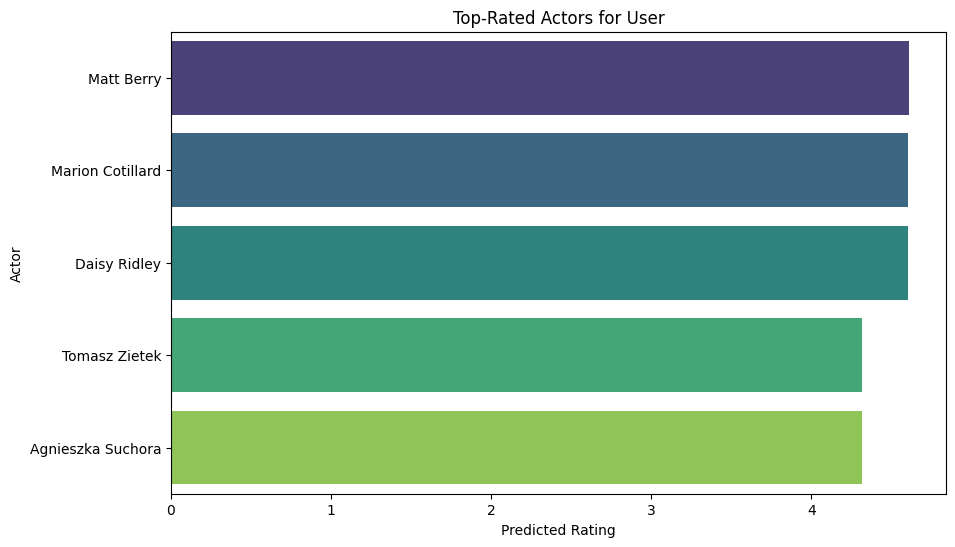

In [ ]:
top_k_pred = np.argsort(y_pred)[-k:][::-1]
top_actors_df = pd.DataFrame({
    'Actor': actors[top_k_pred],
    'Predicted Rating': y_pred[top_k_pred]
})top_k_pred = np.argsort(y_pred)[-k:][::-1]
top_actors_df = pd.DataFrame({
    'Actor': actors[top_k_pred],
    'Predicted Rating': y_pred[top_k_pred]
})
# Visualization: Bar plot for top-rated actors for a sample user
plt.figure(figsize=(10, 6))
sns.barplot(x='Predicted Rating', y='Actor', data=top_actors_df, palette='viridis')
plt.title('Top-Rated Actors for User')
plt.xlabel('Predicted Rating')
plt.ylabel('Actor')
plt.show()
# Visualization: Bar plot for top-rated actors for a sample user
plt.figure(figsize=(10, 6))
sns.barplot(x='Predicted Rating', y='Actor', data=top_actors_df, palette='viridis')
plt.title('Top-Rated Actors for User')
plt.xlabel('Predicted Rating')
plt.ylabel('Actor')
plt.show()